In [ ]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import re
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import keras
from keras import layers
from keras.applications import efficientnet
from keras.layers import TextVectorization

keras.utils.set_random_seed(111)

In [ ]:
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip
!unzip -qq Flickr8k_Dataset.zip
!unzip -qq Flickr8k_text.zip
!rm Flickr8k_Dataset.zip Flickr8k_text.zip

In [ ]:

# Path to the images
IMAGES_PATH = "Flicker8k_Dataset"

# Desired image dimensions
IMAGE_SIZE = (299, 299)

# Vocabulary size

VOCAB_SIZE = 10000

# Fixed length allowed for any sequence
SEQ_LENGTH = 25

# Dimension for the image embeddings and token embeddings
EMBED_DIM = 512

# Per-layer units in the feed-forward network
FF_DIM = 512

# Other training parameters
BATCH_SIZE = 64
EPOCHS = 10
AUTOTUNE = tf.data.AUTOTUNE

In [ ]:

def load_captions_data(filename):
    """Loads captions (text) data and maps them to corresponding images.

    Args:
        filename: Path to the text file containing caption data.

    Returns:
        caption_mapping: Dictionary mapping image names and the corresponding captions
        text_data: List containing all the available captions
    """

    with open(filename) as caption_file:
        caption_data = caption_file.readlines()
        caption_mapping = {}
        text_data = []
        images_to_skip = set()

        for line in caption_data:
            line = line.rstrip("\n")
            # Image name and captions are separated using a tab
            img_name, caption = line.split("\t")

            # Each image is repeated five times for the five different captions.
            # Each image name has a suffix `#(caption_number)`
            img_name = img_name.split("#")[0]
            img_name = os.path.join(IMAGES_PATH, img_name.strip())

            # We will remove caption that are either too short to too long
            tokens = caption.strip().split()

            if len(tokens) < 5 or len(tokens) > SEQ_LENGTH:
                images_to_skip.add(img_name)
                continue

            if img_name.endswith("jpg") and img_name not in images_to_skip:
                # We will add a start and an end token to each caption
                caption = "<start> " + caption.strip() + " <end>"
                text_data.append(caption)

                if img_name in caption_mapping:
                    caption_mapping[img_name].append(caption)
                else:
                    caption_mapping[img_name] = [caption]

        for img_name in images_to_skip:
            if img_name in caption_mapping:
                del caption_mapping[img_name]

        return caption_mapping, text_data


def train_val_split(caption_data, train_size=0.8, shuffle=True):
    """Split the captioning dataset into train and validation sets.

    Args:
        caption_data (dict): Dictionary containing the mapped caption data
        train_size (float): Fraction of all the full dataset to use as training data
        shuffle (bool): Whether to shuffle the dataset before splitting

    Returns:
        Traning and validation datasets as two separated dicts
    """

    # 1. Get the list of all image names
    all_images = list(caption_data.keys())

    # 2. Shuffle if necessary
    if shuffle:
        np.random.shuffle(all_images)

    # 3. Split into training and validation sets
    train_size = int(len(caption_data) * train_size)

    training_data = {
        img_name: caption_data[img_name] for img_name in all_images[:train_size]
    }
    validation_data = {
        img_name: caption_data[img_name] for img_name in all_images[train_size:]
    }

    # 4. Return the splits
    return training_data, validation_data


# Load the dataset
captions_mapping, text_data = load_captions_data("Flickr8k.token.txt")

# Split the dataset into training and validation sets
train_data, valid_data = train_val_split(captions_mapping)
print("Number of training samples: ", len(train_data))
print("Number of validation samples: ", len(valid_data))

Number of training samples:  6114
Number of validation samples:  1529


In [ ]:

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")


strip_chars = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"
strip_chars = strip_chars.replace("<", "")
strip_chars = strip_chars.replace(">", "")

vectorization = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode="int",
    output_sequence_length=SEQ_LENGTH,
    standardize=custom_standardization,
)
vectorization.adapt(text_data)

# Data augmentation for image data
image_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
        layers.RandomContrast(0.3),
    ]
)


In [ ]:

def decode_and_resize(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img


def process_input(img_path, captions):
    return decode_and_resize(img_path), vectorization(captions)


def make_dataset(images, captions):
    dataset = tf.data.Dataset.from_tensor_slices((images, captions))
    dataset = dataset.shuffle(BATCH_SIZE * 8)
    dataset = dataset.map(process_input, num_parallel_calls=AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)

    return dataset


# Pass the list of images and the list of corresponding captions
train_dataset = make_dataset(list(train_data.keys()), list(train_data.values()))

valid_dataset = make_dataset(list(valid_data.keys()), list(valid_data.values()))


In [ ]:

def get_cnn_model():
    base_model = efficientnet.EfficientNetB0(
        input_shape=(*IMAGE_SIZE, 3),
        include_top=False,
        weights="imagenet",
    )
    # We freeze our feature extractor
    base_model.trainable = False
    base_model_out = base_model.output
    base_model_out = layers.Reshape((-1, base_model_out.shape[-1]))(base_model_out)
    cnn_model = keras.models.Model(base_model.input, base_model_out)
    return cnn_model


class TransformerEncoderBlock(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.0
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.dense_1 = layers.Dense(embed_dim, activation="relu")

    def call(self, inputs, training, mask=None):
        inputs = self.layernorm_1(inputs)
        inputs = self.dense_1(inputs)

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=None,
            training=training,
        )
        out_1 = self.layernorm_2(inputs + attention_output_1)
        return out_1


class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim
        self.embed_scale = tf.math.sqrt(tf.cast(embed_dim, tf.float32))

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_tokens = embedded_tokens * self.embed_scale
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)


class TransformerDecoderBlock(layers.Layer):
    def __init__(self, embed_dim, ff_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.ff_dim = ff_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.1
        )
        self.ffn_layer_1 = layers.Dense(ff_dim, activation="relu")
        self.ffn_layer_2 = layers.Dense(embed_dim)

        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()

        self.embedding = PositionalEmbedding(
            embed_dim=EMBED_DIM,
            sequence_length=SEQ_LENGTH,
            vocab_size=VOCAB_SIZE,
        )
        self.out = layers.Dense(VOCAB_SIZE, activation="softmax")

        self.dropout_1 = layers.Dropout(0.3)
        self.dropout_2 = layers.Dropout(0.5)
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, training, mask=None):
        inputs = self.embedding(inputs)
        causal_mask = self.get_causal_attention_mask(inputs)

        if mask is not None:
            padding_mask = tf.cast(mask[:, :, tf.newaxis], dtype=tf.int32)
            combined_mask = tf.cast(mask[:, tf.newaxis, :], dtype=tf.int32)
            combined_mask = tf.minimum(combined_mask, causal_mask)

        attention_output_1 = self.attention_1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=combined_mask,
            training=training,
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
            training=training,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        ffn_out = self.ffn_layer_1(out_2)
        ffn_out = self.dropout_1(ffn_out, training=training)
        ffn_out = self.ffn_layer_2(ffn_out)

        ffn_out = self.layernorm_3(ffn_out + out_2, training=training)
        ffn_out = self.dropout_2(ffn_out, training=training)
        preds = self.out(ffn_out)
        return preds

    def get_causal_attention_mask(self, inputs):
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [
                tf.expand_dims(batch_size, -1),
                tf.constant([1, 1], dtype=tf.int32),
            ],
            axis=0,
        )
        return tf.tile(mask, mult)


class ImageCaptioningModel(keras.Model):
    def __init__(
        self,
        cnn_model,
        encoder,
        decoder,
        num_captions_per_image=5,
        image_aug=None,
    ):
        super().__init__()
        self.cnn_model = cnn_model
        self.encoder = encoder
        self.decoder = decoder
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.acc_tracker = keras.metrics.Mean(name="accuracy")
        self.num_captions_per_image = num_captions_per_image
        self.image_aug = image_aug

    def calculate_loss(self, y_true, y_pred, mask):
        loss = self.loss(y_true, y_pred)
        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask
        return tf.reduce_sum(loss) / tf.reduce_sum(mask)

    def calculate_accuracy(self, y_true, y_pred, mask):
        accuracy = tf.equal(y_true, tf.argmax(y_pred, axis=2))
        accuracy = tf.math.logical_and(mask, accuracy)
        accuracy = tf.cast(accuracy, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        return tf.reduce_sum(accuracy) / tf.reduce_sum(mask)

    def _compute_caption_loss_and_acc(self, img_embed, batch_seq, training=True):
        encoder_out = self.encoder(img_embed, training=training)
        batch_seq_inp = batch_seq[:, :-1]
        batch_seq_true = batch_seq[:, 1:]
        mask = tf.math.not_equal(batch_seq_true, 0)
        batch_seq_pred = self.decoder(
            batch_seq_inp, encoder_out, training=training, mask=mask
        )
        loss = self.calculate_loss(batch_seq_true, batch_seq_pred, mask)
        acc = self.calculate_accuracy(batch_seq_true, batch_seq_pred, mask)
        return loss, acc

    def train_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        if self.image_aug:
            batch_img = self.image_aug(batch_img)

        # 1. Get image embeddings
        img_embed = self.cnn_model(batch_img)

        # 2. Pass each of the five captions one by one to the decoder
        # along with the encoder outputs and compute the loss as well as accuracy
        # for each caption.
        for i in range(self.num_captions_per_image):
            with tf.GradientTape() as tape:
                loss, acc = self._compute_caption_loss_and_acc(
                    img_embed, batch_seq[:, i, :], training=True
                )

                # 3. Update loss and accuracy
                batch_loss += loss
                batch_acc += acc

            # 4. Get the list of all the trainable weights
            train_vars = (
                self.encoder.trainable_variables + self.decoder.trainable_variables
            )

            # 5. Get the gradients
            grads = tape.gradient(loss, train_vars)

            # 6. Update the trainable weights
            self.optimizer.apply_gradients(zip(grads, train_vars))

        # 7. Update the trackers
        batch_acc /= float(self.num_captions_per_image)
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        # 8. Return the loss and accuracy values
        return {
            "loss": self.loss_tracker.result(),
            "acc": self.acc_tracker.result(),
        }

    def test_step(self, batch_data):
        batch_img, batch_seq = batch_data
        batch_loss = 0
        batch_acc = 0

        # 1. Get image embeddings
        img_embed = self.cnn_model(batch_img)

        # 2. Pass each of the five captions one by one to the decoder
        # along with the encoder outputs and compute the loss as well as accuracy
        # for each caption.
        for i in range(self.num_captions_per_image):
            loss, acc = self._compute_caption_loss_and_acc(
                img_embed, batch_seq[:, i, :], training=False
            )

            # 3. Update batch loss and batch accuracy
            batch_loss += loss
            batch_acc += acc

        batch_acc /= float(self.num_captions_per_image)

        # 4. Update the trackers
        self.loss_tracker.update_state(batch_loss)
        self.acc_tracker.update_state(batch_acc)

        # 5. Return the loss and accuracy values
        return {
            "loss": self.loss_tracker.result(),
            "acc": self.acc_tracker.result(),
        }

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker, self.acc_tracker]


cnn_model = get_cnn_model()
encoder = TransformerEncoderBlock(embed_dim=EMBED_DIM, dense_dim=FF_DIM, num_heads=1)
decoder = TransformerDecoderBlock(embed_dim=EMBED_DIM, ff_dim=FF_DIM, num_heads=2)
caption_model = ImageCaptioningModel(
    cnn_model=cnn_model,
    encoder=encoder,
    decoder=decoder,
    image_aug=image_augmentation,
)

16705208/16705208 [==============================] - 0s 0us/step


In [ ]:

# Define the loss function
cross_entropy = keras.losses.SparseCategoricalCrossentropy(
    from_logits=False,
    reduction="sum",
)

# EarlyStopping criteria
early_stopping = keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True)


# Learning Rate Scheduler for the optimizer
class LRSchedule(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, post_warmup_learning_rate, warmup_steps):
        super().__init__()
        self.post_warmup_learning_rate = post_warmup_learning_rate
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        global_step = tf.cast(step, tf.float32)
        warmup_steps = tf.cast(self.warmup_steps, tf.float32)
        warmup_progress = global_step / warmup_steps
        warmup_learning_rate = self.post_warmup_learning_rate * warmup_progress
        return tf.cond(
            global_step < warmup_steps,
            lambda: warmup_learning_rate,
            lambda: self.post_warmup_learning_rate,
        )


# Create a learning rate schedule
num_train_steps = len(train_dataset) * EPOCHS
num_warmup_steps = num_train_steps // 15
lr_schedule = LRSchedule(post_warmup_learning_rate=1e-4, warmup_steps=num_warmup_steps)

# Compile the model
caption_model.compile(optimizer=keras.optimizers.Adam(lr_schedule), loss=cross_entropy)

# Fit the model
caption_model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=valid_dataset,
    callbacks=[early_stopping],
)

Epoch 1/10
96/96 [==============================] - 4053s 42s/step - loss: 19421.3848 - acc: 0.1632 - val_loss: 14925.0586 - val_acc: 0.3185
Epoch 2/10
96/96 [==============================] - 4001s 42s/step - loss: 14251.1943 - acc: 0.3268 - val_loss: 13314.4346 - val_acc: 0.3569
Epoch 3/10
25/96 [======>.......................] - ETA: 42:09 - loss: 13287.3936 - acc: 0.3549

In [ ]:
def generate_caption(img_path=None):   # add a parameter for the image path
    if img_path is None:
        # Select a random image from the validation dataset
        sample_img = np.random.choice(valid_images)
    else:
        sample_img = img_path  # use the provided image path

    # Read the image from the disk
    sample_img = decode_and_resize(sample_img)
    img = sample_img.numpy().clip(0, 255).astype(np.uint8)
    plt.imshow(img)
    plt.show()

    # Pass the image to the CNN
    img = tf.expand_dims(sample_img, 0)
    img = caption_model.cnn_model(img)

    # Pass the image features to the Transformer encoder
    encoded_img = caption_model.encoder(img, training=False)

    # Generate the caption using the Transformer decoder
    decoded_caption = "<start> "
    for i in range(max_decoded_sentence_length):
        tokenized_caption = vectorization([decoded_caption])[:, :-1]
        mask = tf.math.not_equal(tokenized_caption, 0)
        predictions = caption_model.decoder(
            tokenized_caption, encoded_img, training=False, mask=mask
        )
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = index_lookup[sampled_token_index]
        if sampled_token == "<end>":
            break
        decoded_caption += " " + sampled_token

    decoded_caption = decoded_caption.replace("<start> ", "")
    decoded_caption = decoded_caption.replace(" <end>", "").strip()
    print("Predicted Caption: ", decoded_caption)

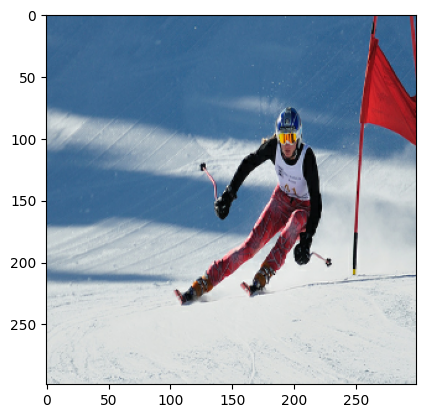

Predicted Caption:  a man in a black and white helmet is skiing down a snowy hill


In [ ]:
generate_caption()

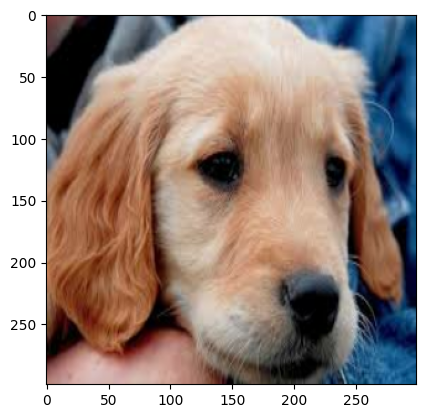

Predicted Caption:  a dog is chewing on a toy


In [ ]:
generate_caption('/content/images (1).jpeg')

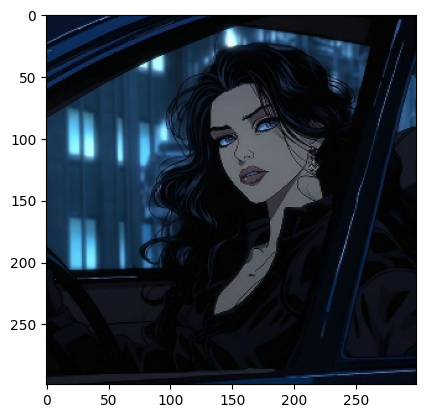

Predicted Caption:  a woman in a black and white shirt is standing in front of a large black and white building


In [ ]:
generate_caption('/content/Follow the creator or comment (check desc if ur an aspiring anime artist x).jpg')

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import string

# Constants
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32  # Reduced batch size
EMBED_DIM = 256
RNN_UNITS = 512
EPOCHS = 20
VOCAB_SIZE = 10000
MAX_CAPTION_LENGTH = 20
AUTOTUNE = tf.data.AUTOTUNE

# Function to load a smaller dataset for testing
def load_small_dataset():
    num_samples = 200  # Reduce number of samples for testing
    images = np.random.rand(num_samples, *IMAGE_SIZE, 3)
    captions = ["<start> " + ''.join(np.random.choice(list(string.ascii_lowercase), 10)) + " <end>" for _ in range(num_samples)]

    tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=VOCAB_SIZE, oov_token="<unk>", filters='')
    tokenizer.fit_on_texts(captions)
    tokenizer.word_index['<pad>'] = 0
    tokenizer.index_word[0] = '<pad>'

    tokenized_captions = tokenizer.texts_to_sequences(captions)
    max_len = max(len(cap) for cap in tokenized_captions)
    padded_captions = tf.keras.preprocessing.sequence.pad_sequences(tokenized_captions, maxlen=max_len, padding='post')

    train_images, val_images = images[:160], images[160:]
    train_captions, val_captions = padded_captions[:160], padded_captions[160:]

    train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_captions))
    val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_captions))

    def preprocess_image(image, caption):
        image = tf.image.resize(image, IMAGE_SIZE)
        return image, caption

    train_dataset = (
        train_dataset
        .map(preprocess_image, num_parallel_calls=AUTOTUNE)
        .shuffle(160)  # Adjust shuffle size accordingly
        .batch(BATCH_SIZE)
        .prefetch(AUTOTUNE)
    )

    val_dataset = (
        val_dataset
        .map(preprocess_image, num_parallel_calls=AUTOTUNE)
        .batch(BATCH_SIZE)
        .prefetch(AUTOTUNE)
    )

    return train_dataset, val_dataset, tokenizer

train_dataset, val_dataset, tokenizer = load_small_dataset()

# Remaining code remains unchanged from your original implementation


# Define CNN feature extractor
def get_cnn_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(*IMAGE_SIZE, 3)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu')
    ])
    return model

# Define RNN-based decoder
class CaptionDecoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embed_dim, rnn_units):
        super(CaptionDecoder, self).__init__()
        self.embedding = tf.keras.layers.Embedding(vocab_size, embed_dim)
        self.rnn = tf.keras.layers.LSTM(rnn_units, return_sequences=True, return_state=True)
        self.fc = tf.keras.layers.Dense(vocab_size)

    def call(self, features, captions):
        # Embed captions
        captions = self.embedding(captions)

        # Expand features dimensions and concatenate
        features = tf.expand_dims(features, axis=1)
        features = tf.repeat(features, repeats=tf.shape(captions)[1], axis=1)
        inputs = tf.concat([features, captions], axis=-1)  # Concatenate along the last axis

        # LSTM layer
        outputs, _, _ = self.rnn(inputs)

        # Final dense layer
        output = self.fc(outputs)
        return output

# Create the image captioning model
class ImageCaptioningModel(tf.keras.Model):
    def __init__(self, cnn_model, decoder):
        super(ImageCaptioningModel, self).__init__()
        self.cnn_model = cnn_model
        self.decoder = decoder
        self.loss_tracker = tf.keras.metrics.Mean(name='loss')

    def call(self, img, captions):
        features = self.cnn_model(img)
        output = self.decoder(features, captions)
        return output

    def compute_loss(self, img, captions):
        output = self(img, captions[:, :-1])
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)(
            captions[:, 1:], output)
        return loss

    @property
    def metrics(self):
        return [self.loss_tracker]

# Instantiate models and compile
cnn_model = get_cnn_model()
decoder = CaptionDecoder(vocab_size=VOCAB_SIZE, embed_dim=EMBED_DIM, rnn_units=RNN_UNITS)
caption_model = ImageCaptioningModel(cnn_model, decoder)
caption_model.compile(optimizer='adam', loss=None)

# Define training and validation steps
def train_caption_model(model, train_data, val_data, epochs=EPOCHS):
    optimizer = tf.keras.optimizers.Adam()
    for epoch in range(epochs):
        print(f'Epoch {epoch+1}/{epochs}')
        for step, (img_batch, caption_batch) in enumerate(train_data):
            with tf.GradientTape() as tape:
                loss = model.compute_loss(img_batch, caption_batch)
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))
            model.loss_tracker.update_state(loss)

            if step % 100 == 0:
                print(f'Step {step}, Loss: {model.loss_tracker.result()}')

        # Validation
        val_loss = []
        for img_val, cap_val in val_data:
            loss_val = model.compute_loss(img_val, cap_val)
            val_loss.append(loss_val)
        print(f'Validation Loss: {np.mean(val_loss)}')

train_caption_model(caption_model, train_dataset, val_dataset)

# Generate captions for new images
def generate_caption(img):
    features = cnn_model(img)
    start_token = tokenizer.word_index['<start>']
    dec_input = tf.expand_dims([start_token], 0)
    result = []
    for i in range(MAX_CAPTION_LENGTH):
        predictions = decoder(features, dec_input)
        predictions = tf.squeeze(predictions, axis=0)
        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])
        if tokenizer.index_word[predicted_id] == '<end>':
            return ' '.join(result)
        dec_input = tf.expand_dims([predicted_id], 0)
    return ' '.join(result)

# Example usage
sample_img = np.random.rand(1, *IMAGE_SIZE, 3)  # Replace with your image loading
caption = generate_caption(sample_img)
print(f'Generated Caption: {caption}')


Epoch 1/20
Step 0, Loss: 9.209859848022461
Validation Loss: 7.031648635864258
Epoch 2/20
Step 0, Loss: 8.107678413391113
Validation Loss: 5.135152816772461
Epoch 3/20
Step 0, Loss: 6.749000072479248
Validation Loss: 5.331617832183838
Epoch 4/20
Step 0, Loss: 5.74339485168457
Validation Loss: 5.316875457763672
Epoch 5/20
Step 0, Loss: 5.131444454193115
Validation Loss: 5.537595748901367
Epoch 6/20
Step 0, Loss: 4.7126569747924805
Validation Loss: 5.670546531677246
Epoch 7/20
Step 0, Loss: 4.410319805145264
Validation Loss: 6.044830322265625
Epoch 8/20
Step 0, Loss: 4.1824049949646
Validation Loss: 6.011629581451416
Epoch 9/20
Step 0, Loss: 4.004591941833496
Validation Loss: 6.151953220367432
Epoch 10/20
Step 0, Loss: 3.861473321914673
Validation Loss: 6.176325798034668
Epoch 11/20
Step 0, Loss: 3.7438104152679443
Validation Loss: 6.2825026512146
Epoch 12/20
Step 0, Loss: 3.645038604736328
Validation Loss: 6.302291393280029
Epoch 13/20
Step 0, Loss: 3.5608770847320557
Validation Loss: 6.